In [ ]:
# # Global plotting layout: prevent clipped labels/titles across all figures
# import matplotlib as mpl
# import matplotlib.pyplot as plt

# # Prefer constrained layout for better spacing; affects all future figures
# mpl.rcParams['figure.constrained_layout.use'] = True
# # When saving, also tighten the bounding box
# mpl.rcParams['savefig.bbox'] = 'tight'

<!-- # Main plots

> This notebook contains the plots of contextual fraction vs various physical quantities for two qutrit UDW detectors interacting with a quantum field. -->


In [2]:
'''This cell imports the necessary libraries and modules for the analysis.'''
import sys, os
from pathlib import Path

# Robustly ensure 'src' is on sys.path (works whether CWD is repo root or notebooks/)
for p in [Path.cwd(), *Path.cwd().parents]:
    cand = p / "src"
    if cand.exists():
        sys.path.insert(0, str(cand))
        break

import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)

# Importing modules
from qft.udw_qutrits import detector_state      
from optimization.lin_prog import contextual_fraction
from utils.state_checks import is_valid_state, validate_and_print


plt.rcParams.update({
    "text.usetex": True,
    "text.latex.preamble": r"\usepackage{lmodern}",
    "font.family": "serif",
    "font.serif": ["Computer Modern Roman"],
})


def reduce_state(rho: np.ndarray) -> np.ndarray:
    """
    Partial trace over the second qutrit (B) of a 2-qutrit density matrix.

    Parameters
    ----------
    rho : np.ndarray
        9x9 density matrix for a 2-qutrit system (A⊗B), dtype complex recommended.

    Returns
    -------
    np.ndarray
        3x3 reduced density matrix for the first qutrit (A).
    """
    rho = np.asarray(rho)
    if rho.shape != (9, 9):
        raise ValueError("rho must be a 9x9 matrix for a 2-qutrit system.")

    # Reshape to indices [i_A, i_B, j_A, j_B]
    rho_reshaped = rho.reshape(3, 3, 3, 3)

    # Trace over B: sum over i_B == j_B
    rho_A = np.trace(rho_reshaped, axis1=1, axis2=3)  # shape (3,3)

    return rho_A


# Product state: should return rho_A
rho_A_true = np.array([[1,0,0],[0,0,0],[0,0,0]], complex)
rho_B_true = np.array([[0,0,0],[0,1,0],[0,0,0]], complex)
# rho_B = np.eye(3)/3
rho_prod_1 = np.kron(rho_A_true, rho_B_true)
rho_prod_2 = np.kron(rho_B_true, rho_A_true)
assert np.allclose(reduce_state(rho_prod_1), rho_A_true)
assert np.allclose(reduce_state(rho_prod_2), rho_B_true)

# Maximally entangled |Φ⟩ = (|00⟩+|11⟩+|22⟩)/√3: reduced is I/3
phi = sum(np.kron(np.eye(3)[k], np.eye(3)[k]) for k in range(3))/np.sqrt(3)
rho_ME = np.outer(phi, phi.conj())
assert np.allclose(reduce_state(rho_ME), np.eye(3)/3)


## Contextual fraction vs gap*switching (fixed R)

In [ ]:
'''This cell generates the plots for contextual fraction vs gap for different detector types.'''


# Fixed parameters
switching = 1.0
separation = 0
smearing = 0.1
lam = 1e-3
regulator = 1.0
regularization = "heaviside"  # used by Q_term but detector_type/group decide which terms contribute

colors = ["#000000","#332288","#117733","#88CCEE","#DDCC77", "#CC6677", "#AA4499","#882255"]

group_types = [
                # ("SU2", "point_like"), 
                ("SU2", "smeared"), 
                # ("HW", "smeared")
                ]
# labels = {
#     # ("SU2", "point_like"): "SU(2), point like",
#     ("SU2", "smeared"): "SU(2), smeared",
#     # ("HW", "smeared"): "HW, smeared"
# }

# Sweep gaps
gaps = np.linspace(0.0, 5, 30)  # avoid zero to keep numerics well-behaved
deez = [0.2, 0.5, 1, 5]

plt.figure(figsize=(4.8,3.6))

rho_type = "product"
for group, detector_type in group_types:
            cf_vals = []
            for gap in gaps:
                rho = detector_state(
                    gap=switching,
                    switching=gap,
                    separation=0,
                    regulator=regulator,
                    smearing=smearing,
                    regularization=regularization,
                    detector_type=detector_type,
                    group=group,
                    lam=lam,
                )
                if is_valid_state(rho):
                    if rho_type == "entangled":
                        rho_final = rho
                        # rho_final = np.kron(rho1, rho1)
                    elif rho_type == "product":
                        rho1 = reduce_state(rho)
                        #rho_final = np.kron(rho1, np.eye(3)*(1/3))
                        rho_final = np.kron(rho1, rho1)
                    
                    res = contextual_fraction(rho_final) 

                    if not res.get("success", False):
                        cf_vals.append(np.nan)
                    else:
                        cf_vals.append(res.get("b", np.nan))
                else:
                    print("Invalid state detected at gap =", gap)
                    validate_and_print(rho)
                    break

            cf_vals = np.array(cf_vals)/(lam**2)
            label = r"$\rho_a \otimes \rho_b$"
            linestyle = "-" if rho_type == "product" else linestyles[idx % len(linestyles)]
            plt.plot(gaps, cf_vals, lw=1.5, label=label, linestyle=linestyle,color=colors[0])

linestyles = [ "--", "-.", ":", (0, (3, 1, 1, 1)), (0, (1, 1))]  # Add more if needed
rho_types = [
              # "product" ,
              "entangled"
        ]

for idx, d in enumerate(deez): 
    linestyle = linestyles[idx % len(linestyles)]
    for rho_type in rho_types:
        for group, detector_type in group_types:
            cf_vals = []
            for gap in gaps:
                rho = detector_state(
                    gap=switching,
                    switching=gap,
                    separation=d,
                    regulator=regulator,
                    smearing=smearing,
                    regularization=regularization,
                    detector_type=detector_type,
                    group=group,
                    lam=lam,
                )
                if is_valid_state(rho):
                    if rho_type == "entangled":
                        rho_final = rho
                        # rho_final = np.kron(rho1, rho1)
                    elif rho_type == "product":
                        rho1 = reduce_state(rho)
                        #rho_final = np.kron(rho1, np.eye(3)*(1/3))
                        rho_final = np.kron(rho1, rho1)
                    
                    res = contextual_fraction(rho_final) 

                    if not res.get("success", False):
                        cf_vals.append(np.nan)
                    else:
                        cf_vals.append(res.get("b", np.nan))
                else:
                    print("Invalid state detected at gap =", gap)
                    validate_and_print(rho)
                    break

            cf_vals = np.array(cf_vals)/(lam**2)
            label = rf"$\rho_{{ab}}$, $d\Omega={d}$"
            linestyle = "-" if rho_type == "product" else linestyles[idx % len(linestyles)]
            plt.plot(gaps, cf_vals, lw=1.5, label=label, linestyle=linestyle,color=colors[idx+1])



plt.xlabel(r"$\Omega T$",fontsize=14)
plt.ylabel(r"CF/$\lambda^2$",fontsize=14)
plt.title(rf"(a) $R\Omega={smearing}$",fontsize=14)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.grid(True, alpha=0.1)
plt.legend()
plt.tight_layout()
plt.savefig("contextual_fraction_vs_gap_different_models_final_final.pdf")
plt.show()


THIS WILL GO TO THE PAPER:

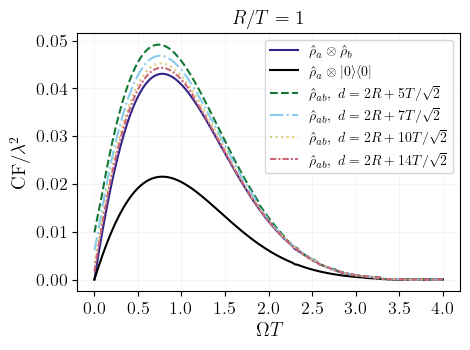

In [10]:
'''This cell generates the plots for contextual fraction vs gap for different detector types.'''


# Fixed parameters
switching = 1.0
separation = 0
smearing = 1
lam = 1e-3
regulator = 1.0
regularization = "heaviside"  # used by Q_term but detector_type/group decide which terms contribute

colors = ["#000000","#332288","#117733","#88CCEE","#DDCC77", "#CC6677", "#AA4499","#882255"]

group_types = [
                # ("SU2", "point_like"), 
                ("SU2", "smeared"), 
                # ("HW", "smeared")
                ]
# labels = {
#     # ("SU2", "point_like"): "SU(2), point like",
#     ("SU2", "smeared"): "SU(2), smeared",
#     # ("HW", "smeared"): "HW, smeared"
# }

# Sweep gaps
gaps = np.linspace(0.0, 4, 250)  # avoid zero to keep numerics well-behaved
# deez = [2*smearing+5/np.sqrt(2), 2*smearing+7/np.sqrt(2), 2*smearing+10/np.sqrt(2), 2*smearing+14/np.sqrt(2)]
deez = [5, 7, 10, 14]

plt.figure(figsize=(4.8,3.6))
rho_type = "product"
###### For product state rhoaXrhob
for group, detector_type in group_types:
            cf_vals = []
            for gap in gaps:
                rho = detector_state(
                    gap=gap,
                    switching=switching,
                    separation=0,
                    regulator=regulator,
                    smearing=smearing,
                    regularization=regularization,
                    detector_type=detector_type,
                    group=group,
                    lam=lam,
                )
                if is_valid_state(rho):
                    rho1 = reduce_state(rho)
                    rho_final = np.kron(rho1, rho1)
                    res = contextual_fraction(rho_final) 
                    if not res.get("success", False):
                        cf_vals.append(np.nan)
                    else:
                        cf_vals.append(res.get("b", np.nan))
                else:
                    print("Invalid state detected at gap =", gap)
                    validate_and_print(rho)
                    break

            cf_vals = np.array(cf_vals)/(lam**2)
            label = r"$\hat{\rho}_a \otimes \hat{\rho}_b$"
            linestyle = "-" if rho_type == "product" else linestyles[idx % len(linestyles)]
            plt.plot(gaps, cf_vals, lw=1.5, label=label, linestyle=linestyle,color=colors[1])

# plt.figure(figsize=(4.8,3.6))
# rho_type = "product"
###### For product state rhoaXI
for group, detector_type in group_types:
            cf_vals = []
            for gap in gaps:
                rho = detector_state(
                    gap=gap,
                    switching=switching,
                    separation=0,
                    regulator=regulator,
                    smearing=smearing,
                    regularization=regularization,
                    detector_type=detector_type,
                    group=group,
                    lam=lam,
                )
                if is_valid_state(rho):
                    rho1 = reduce_state(rho)
                    rho_final = np.kron(rho1, (1/3)*np.eye(3))
                    res = contextual_fraction(rho_final) 
                    if not res.get("success", False):
                        cf_vals.append(np.nan)
                    else:
                        cf_vals.append(res.get("b", np.nan))
                else:
                    print("Invalid state detected at gap =", gap)
                    validate_and_print(rho)
                    break

            cf_vals = np.array(cf_vals)/(lam**2)
            label = r"$\hat{\rho}_a \otimes |0\rangle\langle 0|$"
            linestyle = "-" if rho_type == "product" else linestyles[idx % len(linestyles)]
            plt.plot(gaps, cf_vals, lw=1.5, label=label, linestyle=linestyle,color=colors[0])


linestyles = [ "--", "-.", ":", (0, (3, 1, 1, 1)), (0, (1, 1))]  # Add more if needed



rho_types = [
              "entangled"
        ]

for idx, d in enumerate(deez): 
    linestyle = linestyles[idx % len(linestyles)]
    for rho_type in rho_types:
        for group, detector_type in group_types:
            cf_vals = []
            for gap in gaps:
                rho = detector_state(
                    gap=gap,
                    switching=switching,
                    separation= 2*smearing + (d/np.sqrt(2)),
                    regulator=regulator,
                    smearing=smearing,
                    regularization=regularization,
                    detector_type=detector_type,
                    group=group,
                    lam=lam,
                )
                if is_valid_state(rho):
                    rho_final = rho
                    res = contextual_fraction(rho_final) 

                    if not res.get("success", False):
                        cf_vals.append(np.nan)
                    else:
                        cf_vals.append(res.get("b", np.nan))
                else:
                    print("Invalid state detected at gap =", gap)
                    validate_and_print(rho)
                    break

            cf_vals = np.array(cf_vals)/(lam**2)
            label = rf"$\hat{{\rho}}_{{ab}},\ d=2R+{d}T/\sqrt{{2}}$"
            linestyle = "-" if rho_type == "product" else linestyles[idx % len(linestyles)]
            plt.plot(gaps, cf_vals, lw=1.5, label=label, linestyle=linestyle,color=colors[idx+2])



plt.xlabel(r"$\Omega T$",fontsize=14)
plt.ylabel(r"CF/$\lambda^2$",fontsize=14)
plt.title(rf"$R/T={smearing}$",fontsize=14)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.grid(True, alpha=0.1)
plt.legend()
plt.tight_layout()
plt.savefig("contextual_fraction_vs_gap_large_detectors.pdf")
plt.show()



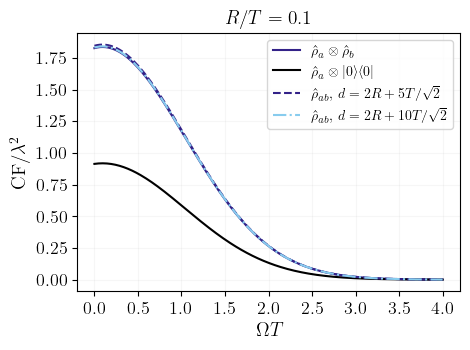

In [8]:
'''This cell generates the plots for contextual fraction vs gap for different detector types.'''


# Fixed parameters
switching = 1.0
separation = 0
smearing = 0.1
lam = 1e-3
regulator = 1.0
regularization = "heaviside"  # used by Q_term but detector_type/group decide which terms contribute

colors = ["#000000","#332288","#117733","#88CCEE","#DDCC77", "#CC6677", "#AA4499","#882255"]

group_types = [
                # ("SU2", "point_like"), 
                ("SU2", "smeared"), 
                # ("HW", "smeared")
                ]
# labels = {
#     # ("SU2", "point_like"): "SU(2), point like",
#     ("SU2", "smeared"): "SU(2), smeared",
#     # ("HW", "smeared"): "HW, smeared"
# }

# Sweep gaps
gaps = np.linspace(0.0, 4, 250)  # avoid zero to keep numerics well-behaved
deez = [5,10]

plt.figure(figsize=(4.8,3.6))

rho_type = "product"
for group, detector_type in group_types:
            cf_vals = []
            for gap in gaps:
                rho = detector_state(
                    gap=gap,
                    switching=switching,
                    separation=0,
                    regulator=regulator,
                    smearing=smearing,
                    regularization=regularization,
                    detector_type=detector_type,
                    group=group,
                    lam=lam,
                )
                if is_valid_state(rho):
                    rho1 = reduce_state(rho)
                    rho_final = np.kron(rho1, rho1)
                    
                    res = contextual_fraction(rho_final) 

                    if not res.get("success", False):
                        cf_vals.append(np.nan)
                    else:
                        cf_vals.append(res.get("b", np.nan))
                else:
                    print("Invalid state detected at gap =", gap)
                    validate_and_print(rho)
                    break

            cf_vals = np.array(cf_vals)/(lam**2)
            label = r"$\hat{\rho}_a \otimes \hat{\rho}_b$"
            linestyle = "-" if rho_type == "product" else linestyles[idx % len(linestyles)]
            plt.plot(gaps, cf_vals, lw=1.5, label=label, linestyle=linestyle,color=colors[1])

for group, detector_type in group_types:
            cf_vals = []
            for gap in gaps:
                rho = detector_state(
                    gap=gap,
                    switching=switching,
                    separation=0,
                    regulator=regulator,
                    smearing=smearing,
                    regularization=regularization,
                    detector_type=detector_type,
                    group=group,
                    lam=lam,
                )
                if is_valid_state(rho):
                    rho1 = reduce_state(rho)
                    rho_final = np.kron(rho1, (1/3)*np.eye(3))
                    res = contextual_fraction(rho_final) 
                    if not res.get("success", False):
                        cf_vals.append(np.nan)
                    else:
                        cf_vals.append(res.get("b", np.nan))
                else:
                    print("Invalid state detected at gap =", gap)
                    validate_and_print(rho)
                    break

            cf_vals = np.array(cf_vals)/(lam**2)
            label = r"$\hat{\rho}_a \otimes |0\rangle\langle 0|$"
            linestyle = "-" if rho_type == "product" else linestyles[idx % len(linestyles)]
            plt.plot(gaps, cf_vals, lw=1.5, label=label, linestyle=linestyle,color=colors[0]) 

linestyles = [ "--", "-.", ":", (0, (3, 1, 1, 1)), (0, (1, 1))]  # Add more if needed
rho_types = [
              "entangled"
        ]

for idx, d in enumerate(deez): 
    linestyle = linestyles[idx % len(linestyles)]
    for rho_type in rho_types:
        for group, detector_type in group_types:
            cf_vals = []
            for gap in gaps:
                rho = detector_state(
                    gap=gap,
                    switching=switching,
                    separation=2*smearing + (d/np.sqrt(2)),
                    regulator=regulator,
                    smearing=smearing,
                    regularization=regularization,
                    detector_type=detector_type,
                    group=group,
                    lam=lam,
                )
                if is_valid_state(rho):
                    rho_final = rho
                    res = contextual_fraction(rho_final) 

                    if not res.get("success", False):
                        cf_vals.append(np.nan)
                    else:
                        cf_vals.append(res.get("b", np.nan))
                else:
                    print("Invalid state detected at gap =", gap)
                    validate_and_print(rho)
                    break

            cf_vals = np.array(cf_vals)/(lam**2)
            label = rf"$\hat{{\rho}}_{{ab}}$, $d=2R+{d}T/\sqrt{{2}}$"
            linestyle = "-" if rho_type == "product" else linestyles[idx % len(linestyles)]
            plt.plot(gaps, cf_vals, lw=1.5, label=label, linestyle=linestyle,color=colors[2*idx+1])



plt.xlabel(r"$\Omega T$",fontsize=14)
plt.ylabel(r"CF/$\lambda^2$",fontsize=14)
plt.title(rf"$R/T={smearing}$",fontsize=14)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.grid(True, alpha=0.1)
plt.legend()
plt.tight_layout()
plt.savefig("contextual_fraction_vs_gap_small_detectors.pdf")
plt.show()

Wigner negativity vs gap for the paper. 

In [3]:

# Importing modules
from qft.udw_qutrits import detector_state      
from magic.wigner_polytope import wigner_inequalities
from utils.state_checks import is_valid_state, validate_and_print

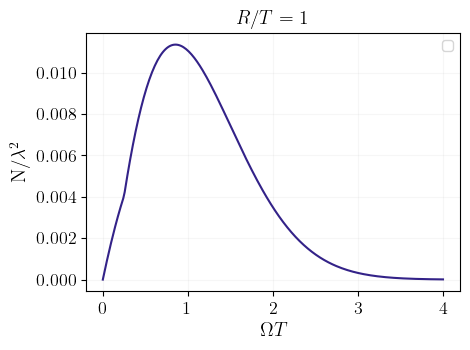

In [28]:

'''This cell generates the plots for Wigner negativity vs gap for different detector types.'''


# Fixed parameters
switching = 1.0
separation = 1.0
smearing = 1
lam = 1e-3
regulator = 1
regularization = "magical"  # used by Q_term but detector_type/group decide which terms contribute

colors = ["#000000","#332288","#117733","#88CCEE","#DDCC77", "#CC6677", "#AA4499","#882255"]

group_types = [ 
                # ("SU2", "point_like"), 
                ("SU2", "smeared"),
                # ("HW", "smeared")
              ]
# labels = {
#     # ("SU2", "point_like"): "SU(2), point like",
#     ("SU2", "smeared"): "SU(2), smeared",
#     # ("HW", "smeared"): "HW, smeared"
# }

plt.figure(figsize=(4.8,3.6))

# Sweep gaps
gaps = np.linspace(0.0, 4, 250)  # avoid zero to keep numerics well-behaved
# deez = [0.1, 0.5, 1, 5]
linestyles = [ "--", "-.", ":", (0, (3, 1, 1, 1))]  # Add more if needed
# for idx, d in enumerate(deez): 

# linestyle = linestyles[idx % len(linestyles)]

for group, detector_type in group_types:
    wn_vals = []  # max violation per gap
    violated_points_list = []  # list of violating (i,j) points per gap
    for gap in gaps:
        rho = detector_state(
            gap=gap,
            switching=switching,
            separation=separation,
            regulator=regulator,
            smearing=smearing,
            regularization=regularization,
            detector_type=detector_type,
            group=group,
            lam=lam,
        )
        if is_valid_state(rho):
            rho_1 = reduce_state(rho)  # reduce to first qutrit
            # max_violation, violating_points = wigner_inequalities(rho_1)
            max_violation, violating_points, violation_sum = wigner_inequalities(rho_1, include_sum=True)
            # value = np.log(max_violation/3 + (1 + rho[0, 0])/2)
            wn_vals.append(violation_sum * (1/3)* (1/lam**2))
            violated_points_list.append(violating_points)
            # if max_violation > 0:
                # print(f"[{group}, {detector_type}] gap={gap:.3g}: violated points = {violating_points}")
        else:
            print("Invalid state detected at gap =", gap)
            validate_and_print(rho)
            break

    wn_vals = np.array(wn_vals)
    # label = f"d={d}"
    plt.plot(gaps[:len(wn_vals)], wn_vals, lw=1.5, color = colors[1])


# plt.xlabel(r"{$\Omega T$",fontsize=14)
# plt.ylabel(r"{Max Wigner inequality violation}",fontsize=14)
# # plt.title(rf"(a) $d/\sigma={separation}$, $R/\sigma={smearing}$, $\lambda={lam}$",fontsize=14)
# plt.title(rf"$R/T={smearing}$",fontsize=14)
# plt.xticks(fontsize=13)
# plt.yticks(fontsize=13)
# plt.grid(True, alpha=0.3)
# plt.legend(title="Detector group and type")
# plt.tight_layout()
# # plt.savefig("wigner_negativity_vs_gap_different_models.pdf")
# plt.show()
plt.xlabel(r"$\Omega T$",fontsize=14)
plt.ylabel(r"N/$\lambda^2$",fontsize=14)
plt.title(rf"$R/T={smearing}$",fontsize=14)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.grid(True, alpha=0.1)
plt.legend()
plt.tight_layout()
plt.savefig("magic_vs_gap_big_detectors.pdf")
plt.show()

Appendix plot for magic:

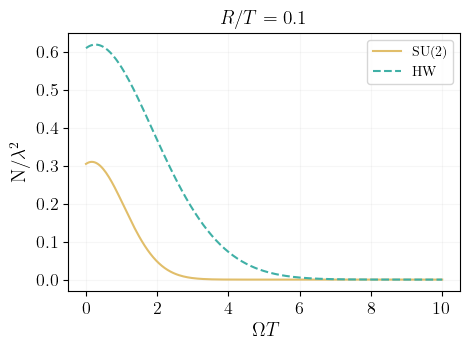

In [26]:
'''This cell generates the plots for Wigner negativity vs gap for different detector types.'''


# Fixed parameters
switching = 1.0
separation = 1.0
smearing = 0.1
lam = 1e-3
regulator = 1
regularization = "magical"  # used by Q_term but detector_type/group decide which terms contribute

colors = ["#000000","#332288","#117733","#88CCEE","#DDCC77", "#CC6677", "#AA4499","#882255"]

group_types = [ 
                # ("SU2", "point_like"), 
                ("SU2", "smeared"),
                ("HW", "smeared")
              ]
labels = {
#     # ("SU2", "point_like"): "SU(2), point like",
    ("SU2", "smeared"): "SU(2)",
    ("HW", "smeared"): "HW"
}


colors = ["#E1BE6A", "#40B0A6"]

plt.figure(figsize=(4.8,3.6))

# Sweep gaps
gaps = np.linspace(0.0, 10, 250)  # avoid zero to keep numerics well-behaved
# deez = [0.1, 0.5, 1, 5]
linestyles = [ "--", "-.", ":", (0, (3, 1, 1, 1))]  # Add more if needed
# for idx, d in enumerate(deez): 

# linestyle = linestyles[idx % len(linestyles)]

for group, detector_type in group_types:
    wn_vals = []  # max violation per gap
    violated_points_list = []  # list of violating (i,j) points per gap
    for gap in gaps:
        rho = detector_state(
            gap=gap,
            switching=switching,
            separation=separation,
            regulator=regulator,
            smearing=smearing,
            regularization=regularization,
            detector_type=detector_type,
            group=group,
            lam=lam,
        )
        if is_valid_state(rho):
            rho_1 = reduce_state(rho)  # reduce to first qutrit
            # max_violation, violating_points = wigner_inequalities(rho_1)
            max_violation, violating_points, violation_sum = wigner_inequalities(rho_1, include_sum=True)
            # value = np.log(max_violation/3 + (1 + rho[0, 0])/2)
            wn_vals.append(violation_sum * (1/3)* (1/lam**2))
            violated_points_list.append(violating_points)
            # if max_violation > 0:
                # print(f"[{group}, {detector_type}] gap={gap:.3g}: violated points = {violating_points}")
        else:
            print("Invalid state detected at gap =", gap)
            validate_and_print(rho)
            break

    wn_vals = np.array(wn_vals)
    # label = f"d={d}"
    # plt.plot(gaps[:len(wn_vals)], wn_vals, lw=1.5, labels = labels)
    # plt.plot(gaps[:len(wn_vals)], wn_vals, lw=1.5, label=labels[(group, detector_type)], color = "#dbbf76")
    plt.plot(gaps[:len(wn_vals)], wn_vals, lw=1.5, label=labels[(group, detector_type)],color=colors[0] if group == "SU2" else colors[1], linestyle="--" if group == "HW" else "-" )


# plt.xlabel(r"{$\Omega T$",fontsize=14)
# plt.ylabel(r"{Max Wigner inequality violation}",fontsize=14)
# # plt.title(rf"(a) $d/\sigma={separation}$, $R/\sigma={smearing}$, $\lambda={lam}$",fontsize=14)
# plt.title(rf"$R/T={smearing}$",fontsize=14)
# plt.xticks(fontsize=13)
# plt.yticks(fontsize=13)
# plt.grid(True, alpha=0.3)
# plt.legend(title="Detector group and type")
# plt.tight_layout()
# # plt.savefig("wigner_negativity_vs_gap_different_models.pdf")
# plt.show()
plt.xlabel(r"$\Omega T$",fontsize=14)
plt.ylabel(r"N/$\lambda^2$",fontsize=14)
plt.title(rf"$R/T={smearing}$",fontsize=14)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.grid(True, alpha=0.1)
plt.legend()
plt.tight_layout()
plt.savefig("magic_vs_gap_different_models.pdf")
plt.show()

In [ ]:
'''This cell generates the plots for contextual fraction vs gap for different detector types.'''


# Fixed parameters
switching = 1.0
separation = 0
smearing = 0.4
lam = 1e-3
regulator = 1.0
regularization = "heaviside"  # used by Q_term but detector_type/group decide which terms contribute

colors = ["#000000","#332288","#117733","#88CCEE","#DDCC77", "#CC6677", "#AA4499","#882255"]

group_types = [
                # ("SU2", "point_like"), 
                ("SU2", "smeared"), 
                # ("HW", "smeared")
                ]
# labels = {
#     # ("SU2", "point_like"): "SU(2), point like",
#     ("SU2", "smeared"): "SU(2), smeared",
#     # ("HW", "smeared"): "HW, smeared"
# }

# Sweep gaps
gaps = np.linspace(0.0, 3, 10)  # avoid zero to keep numerics well-behaved
deez = [2*smearing+5/np.sqrt(2), 2*smearing+7/np.sqrt(2), 2*smearing+10/np.sqrt(2), 2*smearing+14/np.sqrt(2)]

plt.figure(figsize=(4.8,3.6))

rho_type = "product"
for group, detector_type in group_types:
            cf_vals = []
            for gap in gaps:
                rho = detector_state(
                    gap=gap,
                    switching=switching,
                    separation=0,
                    regulator=regulator,
                    smearing=smearing,
                    regularization=regularization,
                    detector_type=detector_type,
                    group=group,
                    lam=lam,
                )
                if is_valid_state(rho):
                    # if rho_type == "entangled":
                    #     rho_final = rho
                    #     # rho_final = np.kron(rho1, rho1)
                    # elif rho_type == "product":
                    rho1 = reduce_state(rho)
                    # rho_final = np.kron(rho1, np.eye(3)*(1/3))
                    rho_final = np.kron(rho1, rho1)
                    
                    res = contextual_fraction(rho_final) 

                    if not res.get("success", False):
                        cf_vals.append(np.nan)
                    else:
                        cf_vals.append(res.get("b", np.nan))
                else:
                    print("Invalid state detected at gap =", gap)
                    validate_and_print(rho)
                    break

            cf_vals = np.array(cf_vals)/(lam**2)
            label = r"$\rho_a \otimes \rho_b$"
            linestyle = "-" if rho_type == "product" else linestyles[idx % len(linestyles)]
            plt.plot(gaps, cf_vals, lw=1.5, label=label, linestyle=linestyle,color=colors[0])

linestyles = [ "--", "-.", ":", (0, (3, 1, 1, 1)), (0, (1, 1))]  # Add more if needed
rho_types = [
            #   "product" ,
              "entangled"
        ]

for idx, d in enumerate(deez): 
    linestyle = linestyles[idx % len(linestyles)]
    for rho_type in rho_types:
        for group, detector_type in group_types:
            cf_vals = []
            for gap in gaps:
                rho = detector_state(
                    gap=gap,
                    switching=switching,
                    separation=d,
                    regulator=regulator,
                    smearing=smearing,
                    regularization=regularization,
                    detector_type=detector_type,
                    group=group,
                    lam=lam,
                )
                if is_valid_state(rho):
                    # if rho_type == "entangled":
                    rho_final = rho
                        # rho_final = np.kron(rho1, rho1)
                    # elif rho_type == "product":
                        # rho1 = reduce_state(rho)
                        # rho_final = np.kron(rho1, np.eye(3)*(1/3))
                        #rho_final = np.kron(rho1, rho1)
                    
                    res = contextual_fraction(rho_final) 

                    if not res.get("success", False):
                        cf_vals.append(np.nan)
                    else:
                        cf_vals.append(res.get("b", np.nan))
                else:
                    print("Invalid state detected at gap =", gap)
                    validate_and_print(rho)
                    break

            cf_vals = np.array(cf_vals)/(lam**2)
            label = rf"$\rho_{{ab}}$, $d\Omega={d}$"
            linestyle = "-" if rho_type == "product" else linestyles[idx % len(linestyles)]
            plt.plot(gaps, cf_vals, lw=1.5, label=label, linestyle=linestyle,color=colors[idx+1])



plt.xlabel(r"$\Omega T$",fontsize=14)
plt.ylabel(r"CF/$\lambda^2$",fontsize=14)
plt.title(rf"$R/T={smearing}$",fontsize=14)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.grid(True, alpha=0.1)
plt.legend()
plt.tight_layout()
# plt.savefig("contextual_fraction_vs_gap_different_models.pdf")
plt.show()

This goes to the paper:

In [ ]:
'''This cell generates the plots for contextual fraction vs gap for different detector types.'''


# Fixed parameters
switching = 1.0
separation = 0
smearing = 0.1
lam = 1e-3
regulator = 1.0
regularization = "heaviside"  # used by Q_term but detector_type/group decide which terms contribute

colors = ["#000000","#332288","#117733","#88CCEE","#DDCC77", "#CC6677", "#AA4499","#882255"]

group_types = [
                # ("SU2", "point_like"), 
                ("SU2", "smeared"), 
                # ("HW", "smeared")
                ]
# labels = {
#     # ("SU2", "point_like"): "SU(2), point like",
#     ("SU2", "smeared"): "SU(2), smeared",
#     # ("HW", "smeared"): "HW, smeared"
# }

# Sweep gaps
gaps = np.linspace(0.0, 0.5, 10)  # avoid zero to keep numerics well-behaved
deez = [2*smearing+5/np.sqrt(2), 2*smearing+7/np.sqrt(2), 2*smearing+10/np.sqrt(2), 2*smearing+14/np.sqrt(2)]

plt.figure(figsize=(4.8,3.6))

rho_type = "product"
for group, detector_type in group_types:
            cf_vals = []
            for gap in gaps:
                rho = detector_state(
                    gap=gap,
                    switching=switching,
                    separation=0,
                    regulator=regulator,
                    smearing=smearing,
                    regularization=regularization,
                    detector_type=detector_type,
                    group=group,
                    lam=lam,
                )
                if is_valid_state(rho):
                    # if rho_type == "entangled":
                    #     rho_final = rho
                    #     # rho_final = np.kron(rho1, rho1)
                    # elif rho_type == "product":
                    rho1 = reduce_state(rho)
                    # rho_final = np.kron(rho1, np.eye(3)*(1/3))
                    rho_final = np.kron(rho1, rho1)
                    
                    res = contextual_fraction(rho_final) 

                    if not res.get("success", False):
                        cf_vals.append(np.nan)
                    else:
                        cf_vals.append(res.get("b", np.nan))
                else:
                    print("Invalid state detected at gap =", gap)
                    validate_and_print(rho)
                    break

            cf_vals = np.array(cf_vals)/(lam**2)
            label = r"$\rho_a \otimes \rho_b$"
            linestyle = "-" if rho_type == "product" else linestyles[idx % len(linestyles)]
            plt.plot(gaps, cf_vals, lw=1.5, label=label, linestyle=linestyle,color=colors[0])

linestyles = [ "--", "-.", ":", (0, (3, 1, 1, 1)), (0, (1, 1))]  # Add more if needed
rho_types = [
            #   "product" ,
              "entangled"
        ]

for idx, d in enumerate(deez): 
    linestyle = linestyles[idx % len(linestyles)]
    for rho_type in rho_types:
        for group, detector_type in group_types:
            cf_vals = []
            for gap in gaps:
                rho = detector_state(
                    gap=gap,
                    switching=switching,
                    separation=d,
                    regulator=regulator,
                    smearing=smearing,
                    regularization=regularization,
                    detector_type=detector_type,
                    group=group,
                    lam=lam,
                )
                if is_valid_state(rho):
                    # if rho_type == "entangled":
                    rho_final = rho
                        # rho_final = np.kron(rho1, rho1)
                    # elif rho_type == "product":
                        # rho1 = reduce_state(rho)
                        # rho_final = np.kron(rho1, np.eye(3)*(1/3))
                        #rho_final = np.kron(rho1, rho1)
                    
                    res = contextual_fraction(rho_final) 

                    if not res.get("success", False):
                        cf_vals.append(np.nan)
                    else:
                        cf_vals.append(res.get("b", np.nan))
                else:
                    print("Invalid state detected at gap =", gap)
                    validate_and_print(rho)
                    break

            cf_vals = np.array(cf_vals)/(lam**2)
            label = rf"$\rho_{{ab}}$, $d\Omega={d}$"
            linestyle = "-" if rho_type == "product" else linestyles[idx % len(linestyles)]
            plt.plot(gaps, cf_vals, lw=1.5, label=label, linestyle=linestyle,color=colors[idx+1])



plt.xlabel(r"$\Omega T$",fontsize=14)
plt.ylabel(r"CF/$\lambda^2$",fontsize=14)
plt.title(rf"$R/T={smearing}$",fontsize=14)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.grid(True, alpha=0.1)
plt.legend()
plt.tight_layout()
# plt.savefig("contextual_fraction_vs_gap_different_models.pdf")
plt.show()

María's old version:

In [ ]:
'''This cell generates the plots for contextual fraction vs gap for different detector types.'''


# Fixed parameters
switching = 1.0
separation = 0
smearing = 0.5
lam = 1e-3
regulator = 1.0
regularization = "heaviside"  # used by Q_term but detector_type/group decide which terms contribute

colors = ["#000000","#332288","#117733","#88CCEE","#DDCC77", "#CC6677", "#AA4499","#882255"]

group_types = [
                # ("SU2", "point_like"), 
                ("SU2", "smeared"), 
                # ("HW", "smeared")
                ]
# labels = {
#     # ("SU2", "point_like"): "SU(2), point like",
#     ("SU2", "smeared"): "SU(2), smeared",
#     # ("HW", "smeared"): "HW, smeared"
# }

# Sweep gaps
gaps = np.linspace(0.0, 5, 10)  # avoid zero to keep numerics well-behaved
deez = [0.2, 0.5, 1, 5]

plt.figure(figsize=(4.8,3.6))

rho_type = "product"
for group, detector_type in group_types:
            cf_vals = []
            for gap in gaps:
                rho = detector_state(
                    gap=gap,
                    switching=switching,
                    separation=0,
                    regulator=regulator,
                    smearing=smearing,
                    regularization=regularization,
                    detector_type=detector_type,
                    group=group,
                    lam=lam,
                )
                if is_valid_state(rho):
                    # if rho_type == "entangled":
                    #     rho_final = rho
                    #     # rho_final = np.kron(rho1, rho1)
                    # elif rho_type == "product":
                    rho1 = reduce_state(rho)
                    # rho_final = np.kron(rho1, np.eye(3)*(1/3))
                    rho_final = np.kron(rho1, rho1)
                    
                    res = contextual_fraction(rho_final) 

                    if not res.get("success", False):
                        cf_vals.append(np.nan)
                    else:
                        cf_vals.append(res.get("b", np.nan))
                else:
                    print("Invalid state detected at gap =", gap)
                    validate_and_print(rho)
                    break

            cf_vals = np.array(cf_vals)/(lam**2)
            label = r"$\rho_a \otimes \rho_b$"
            linestyle = "-" if rho_type == "product" else linestyles[idx % len(linestyles)]
            plt.plot(gaps, cf_vals, lw=1.5, label=label, linestyle=linestyle,color=colors[0])

linestyles = [ "--", "-.", ":", (0, (3, 1, 1, 1)), (0, (1, 1))]  # Add more if needed
rho_types = [
            #   "product" ,
              "entangled"
        ]

for idx, d in enumerate(deez): 
    linestyle = linestyles[idx % len(linestyles)]
    for rho_type in rho_types:
        for group, detector_type in group_types:
            cf_vals = []
            for gap in gaps:
                rho = detector_state(
                    gap=gap,
                    switching=switching,
                    separation=d,
                    regulator=regulator,
                    smearing=smearing,
                    regularization=regularization,
                    detector_type=detector_type,
                    group=group,
                    lam=lam,
                )
                if is_valid_state(rho):
                    # if rho_type == "entangled":
                    rho_final = rho
                        # rho_final = np.kron(rho1, rho1)
                    # elif rho_type == "product":
                        # rho1 = reduce_state(rho)
                        # rho_final = np.kron(rho1, np.eye(3)*(1/3))
                        #rho_final = np.kron(rho1, rho1)
                    
                    res = contextual_fraction(rho_final) 

                    if not res.get("success", False):
                        cf_vals.append(np.nan)
                    else:
                        cf_vals.append(res.get("b", np.nan))
                else:
                    print("Invalid state detected at gap =", gap)
                    validate_and_print(rho)
                    break

            cf_vals = np.array(cf_vals)/(lam**2)
            label = rf"$\rho_{{ab}}$, $d\Omega={d}$"
            linestyle = "-" if rho_type == "product" else linestyles[idx % len(linestyles)]
            plt.plot(gaps, cf_vals, lw=1.5, label=label, linestyle=linestyle,color=colors[idx+1])



plt.xlabel(r"$\Omega T$",fontsize=14)
plt.ylabel(r"CF/$\lambda^2$",fontsize=14)
plt.title(rf"$R/T={smearing}$",fontsize=14)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.grid(True, alpha=0.1)
plt.legend()
plt.tight_layout()
# plt.savefig("contextual_fraction_vs_gap_different_models.pdf")
plt.show()


In [ ]:
'''This cell generates the plots for contextual fraction vs gap for different detector types.'''


# Fixed parameters
switching = 1.0
separation = 0
smearing = 0.1
lam = 1e-3
regulator = 1.0
regularization = "heaviside"  # used by Q_term but detector_type/group decide which terms contribute

colors = ["#000000","#332288","#117733","#88CCEE","#DDCC77", "#CC6677", "#AA4499","#882255"]

group_types = [
                # ("SU2", "point_like"), 
                ("SU2", "smeared"), 
                # ("HW", "smeared")
                ]
# labels = {
#     # ("SU2", "point_like"): "SU(2), point like",
#     ("SU2", "smeared"): "SU(2), smeared",
#     # ("HW", "smeared"): "HW, smeared"
# }

# Sweep gaps
gaps = np.linspace(0.0, 5, 10)  # avoid zero to keep numerics well-behaved
deez = [0.2, 0.5, 1, 5]

plt.figure(figsize=(4.8,3.6))

rho_type = "product"
for group, detector_type in group_types:
            cf_vals = []
            for gap in gaps:
                rho = detector_state(
                    gap=switching,
                    switching=gap,
                    separation=0,
                    regulator=regulator,
                    smearing=smearing,
                    regularization=regularization,
                    detector_type=detector_type,
                    group=group,
                    lam=lam,
                )
                if is_valid_state(rho):
                    if rho_type == "entangled":
                        rho_final = rho
                        # rho_final = np.kron(rho1, rho1)
                    elif rho_type == "product":
                        rho1 = reduce_state(rho)
                        #rho_final = np.kron(rho1, np.eye(3)*(1/3))
                        rho_final = np.kron(rho1, rho1)
                    
                    res = contextual_fraction(rho_final) 

                    if not res.get("success", False):
                        cf_vals.append(np.nan)
                    else:
                        cf_vals.append(res.get("b", np.nan))
                else:
                    print("Invalid state detected at gap =", gap)
                    validate_and_print(rho)
                    break

            cf_vals = np.array(cf_vals)/(lam**2)
            label = r"$\rho_a \otimes \rho_b$"
            linestyle = "-" if rho_type == "product" else linestyles[idx % len(linestyles)]
            plt.plot(gaps, cf_vals, lw=1.5, label=label, linestyle=linestyle,color=colors[0])

linestyles = [ "--", "-.", ":", (0, (3, 1, 1, 1)), (0, (1, 1))]  # Add more if needed
rho_types = [
              # "product" ,
              "entangled"
        ]

for idx, d in enumerate(deez): 
    linestyle = linestyles[idx % len(linestyles)]
    for rho_type in rho_types:
        for group, detector_type in group_types:
            cf_vals = []
            for gap in gaps:
                rho = detector_state(
                    gap=switching,
                    switching=gap,
                    separation=d,
                    regulator=regulator,
                    smearing=smearing,
                    regularization=regularization,
                    detector_type=detector_type,
                    group=group,
                    lam=lam,
                )
                if is_valid_state(rho):
                    if rho_type == "entangled":
                        rho_final = rho
                        # rho_final = np.kron(rho1, rho1)
                    elif rho_type == "product":
                        rho1 = reduce_state(rho)
                        rho_final = np.kron(rho1, np.eye(3)*(1/3))
                        # rho_final = np.kron(rho1, rho1)
                    
                    res = contextual_fraction(rho_final) 

                    if not res.get("success", False):
                        cf_vals.append(np.nan)
                    else:
                        cf_vals.append(res.get("b", np.nan))
                else:
                    print("Invalid state detected at gap =", gap)
                    validate_and_print(rho)
                    break

            cf_vals = np.array(cf_vals)/(lam**2)
            label = rf"$\rho_{{ab}}$, $d\Omega={d}$"
            linestyle = "-" if rho_type == "product" else linestyles[idx % len(linestyles)]
            plt.plot(gaps, cf_vals, lw=1.5, label=label, linestyle=linestyle,color=colors[idx+1])



plt.xlabel(r"$\Omega T$",fontsize=14)
plt.ylabel(r"CF/$\lambda^2$",fontsize=14)
plt.title(rf"$R\Omega={smearing}$",fontsize=14)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.grid(True, alpha=0.1)
plt.legend()
plt.tight_layout()
# plt.savefig("contextual_fraction_vs_gap_different_models.pdf")
plt.show()


In [ ]:
'''This cell generates the plots for contextual fraction vs gap for different detector types.'''


# Fixed parameters
switching = 1.0
lam = 1e-3
regulator = 1.0
regularization = "heaviside"  # used by Q_term but detector_type/group decide which terms contribute

colors = ["#000000","#332288","#117733","#88CCEE","#DDCC77", "#CC6677", "#AA4499","#882255"]

group_types = [
                # ("SU2", "point_like"), 
                ("SU2", "smeared"), 
                # ("HW", "smeared")
                ]
# labels = {
#     # ("SU2", "point_like"): "SU(2), point like",
#     ("SU2", "smeared"): "SU(2), smeared",
#     # ("HW", "smeared"): "HW, smeared"
# }

plt.figure(figsize=(4.8,3.6))

rho_types = [
              "product",
              "entangled"
        ]

rho_type_labels = {
    "product": r"$\rho_a\otimes\rho_b$",
    "entangled": r"$\rho_{{ab}}$"
}

# Sweep gaps
gaps = np.linspace(0.1, 5, 5)  # avoid zero to keep numerics well-behaved
deez = [0.1, 0.5, 1, 5]

linestyles = [ "--", "-.", ":", (0, (3, 1, 1, 1))]  # Add more if needed

for idx, d in enumerate(deez): 
    linestyle = linestyles[idx % len(linestyles)]
    for rho_type in rho_types:
        for group, detector_type in group_types:
            cf_vals = []
            for gap in gaps:
                rho = detector_state(
                    gap=gap,
                    switching=switching,
                    separation=d,
                    regulator=regulator,
                    smearing=0.1*d,
                    regularization=regularization,
                    detector_type=detector_type,
                    group=group,
                    lam=lam,
                )
                if is_valid_state(rho):
                    if rho_type == "entangled":
                        rho_final = rho
                        # rho_final = np.kron(rho1, rho1)
                    elif rho_type == "product":
                        rho1 = reduce_state(rho)
                        #rho_final = np.kron(rho1, np.eye(3)*(1/3))
                        rho_final = np.kron(rho1, rho1)
                    
                    res = contextual_fraction(rho_final) 

                    if not res.get("success", False):
                        cf_vals.append(np.nan)
                    else:
                        cf_vals.append(res.get("b", np.nan))
                else:
                    print("Invalid state detected at gap =", gap)
                    validate_and_print(rho)
                    break

            cf_vals = np.array(cf_vals)
            label = rf"{rho_type_labels[rho_type]}, $d/T={d}$"
            linestyle = "-" if rho_type == "product" else linestyles[idx % len(linestyles)]
            color = colors[idx+1]
            plt.plot(gaps, cf_vals, lw=1.5, label=label, linestyle=linestyle, color=color)

plt.xlabel(r"$\Omega T$",fontsize=14)
plt.ylabel(r"CF",fontsize=14)
plt.title(rf" $R/d=0.1$",fontsize=14)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.grid(True, alpha=0.1)
plt.legend()
plt.tight_layout()
# plt.savefig("contextual_fraction_vs_gap_different_models.pdf")
plt.show()

In [ ]:
'''This cell generates the plots for contextual fraction vs gap for different detector types.'''


# Fixed parameters
switching = 1.0
lam = 1e-3
regulator = 1.0
regularization = "heaviside"  # used by Q_term but detector_type/group decide which terms contribute

colors = ["#000000","#332288","#117733","#88CCEE","#DDCC77", "#CC6677", "#AA4499","#882255"]

group_types = [
                # ("SU2", "point_like"), 
                ("SU2", "smeared"), 
                # ("HW", "smeared")
                ]
# labels = {
#     # ("SU2", "point_like"): "SU(2), point like",
#     ("SU2", "smeared"): "SU(2), smeared",
#     # ("HW", "smeared"): "HW, smeared"
# }

plt.figure(figsize=(4.8,3.6))

rho_types = [
              "product",
              "entangled"
        ]

rho_type_labels = {
    "product": r"$\rho_a\otimes\rho_b$",
    "entangled": r"$\rho_{{ab}}$"
}

# Sweep gaps
gaps = np.linspace(0.0, 5, 30)  # avoid zero to keep numerics well-behaved
deez = [0.1, 0.5, 1, 5]

linestyles = [ "--", "-.", ":", (0, (3, 1, 1, 1))]  # Add more if needed

for idx, d in enumerate(deez): 
    linestyle = linestyles[idx % len(linestyles)]
    for rho_type in rho_types:
        for group, detector_type in group_types:
            cf_vals = []
            for gap in gaps:
                rho = detector_state(
                    gap=switching,
                    switching=gap,
                    separation=d,
                    regulator=regulator,
                    smearing=0.05*d,
                    regularization=regularization,
                    detector_type=detector_type,
                    group=group,
                    lam=lam,
                )
                if is_valid_state(rho):
                    if rho_type == "entangled":
                        rho_final = rho
                        # rho_final = np.kron(rho1, rho1)
                    elif rho_type == "product":
                        rho1 = reduce_state(rho)
                        #rho_final = np.kron(rho1, np.eye(3)*(1/3))
                        rho_final = np.kron(rho1, rho1)
                    
                    res = contextual_fraction(rho_final) 

                    if not res.get("success", False):
                        cf_vals.append(np.nan)
                    else:
                        cf_vals.append(res.get("b", np.nan))
                else:
                    print("Invalid state detected at gap =", gap)
                    validate_and_print(rho)
                    break

            cf_vals = np.array(cf_vals)/(lam**2)
            label = rf"{rho_type_labels[rho_type]}, $d\Omega={d}$"
            linestyle = "-" if rho_type == "product" else linestyles[idx % len(linestyles)]
            color = colors[idx+1]
            plt.plot(gaps, cf_vals, lw=1.5, label=label, linestyle=linestyle, color=color)

plt.xlabel(r"$\Omega T$",fontsize=14)
plt.ylabel(r"CF$/\lambda^2$",fontsize=14)
plt.title(rf"(b) $R/d=0.01$",fontsize=14)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.grid(True, alpha=0.1)
plt.legend()
plt.tight_layout()
plt.savefig("contextual_fraction_vs_gap_different_models_final_final_smearing_d_3.pdf")
plt.show()